In [1]:
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray import DataArray
import pandas as pd
from PyEMD import EEMD
import pylab as plt

In [3]:
# EEMD on SPG index
# SPG index based on potential density 
data       = xr.open_dataset("/work/uo1075/u241321/data/u241321/data_cdo/rhopoto_1969-2019_assi.nc") 
lat_min, lat_max = (50,62) # index3 
lon_min, lon_max = (-55,-35)
var11 = data['rhopoto'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), depth=310)
var1 = np.mean(var11, axis=1)
# weight average 
weights = np.cos(np.deg2rad(var1.lat))
weights.name = "weights"
air_weighted = var1.weighted(weights)
y = air_weighted.mean(("lon", "lat"))


# Assign EEMD to `eemd` variable
Spg = y.values
t = np.arange(1970,2020,1)

# EEMD options
max_imf=3
# Prepare and run EEMD
eemd = EEMD(trials=10000, FIXE_H=10, DTYPE=np.float16, noise_width=0.2)   #max_imfs=10)
eemd.noise_seed(6021)

# Execute EEMD on S
eIMFs_spg = eemd.eemd(Spg, t, max_imf)
nIMFs = eIMFs_spg.shape[0]

# eemd.all_imfs # A dictionary with all computed imfs for every member.
# eemd.ensemble_count() # 1000,1000,1000,1000,333 (the fifth component(trend) consists of 333 members) Count of imfs observed for given order, e.g. 1st proto-imf, in the whole ensemble.
# eemd.ensemble_std()   # Pointwise standard deviation over computed ensemble
imfs, residue = eemd.get_imfs_and_residue() # imfs: same as eIMFs; residue = input - np.sum(eIMFs, axis=0)


# Whitenoise statistical significance test.
# Performs whitenoise test as described by Wu & Huang [Wu2004].
from PyEMD.checks import whitenoise_check
significant_imfs = whitenoise_check(eIMFs_spg, test_name='apriori', alpha=0.99)
significant_imfs   # {1: 1, 2: 1, 3: 1, 4: 0}



{1: 1, 2: 1, 3: 1, 4: 1}

In [4]:
mode = np.zeros((5,50))

mode[0,:] = Spg
mode[1,:] = eIMFs_spg[0,:]
mode[2,:] = eIMFs_spg[1,:]
mode[3,:] = eIMFs_spg[2,:]
mode[4,:] = eIMFs_spg[3,:]

np.save("/work/uo1075/u241321/data/EEMD_spg_density", mode)

In [2]:
assi = np.load("/work/uo1075/u241321/data/EEMD_spg_density.npy")   # (5,50) mode(input, c1-c4), time
hind = np.load("/work/uo1075/u241321/data/EEMD_spg_density_dt.npy")   # (5,50) mode(input, c1-c4), time

# np.corrcoef(spg[0,:], mode[0,:])[0,1]

In [7]:
np.corrcoef(spg[1,:], mode[1,:])[0,1]

0.828442670227328

In [8]:
np.corrcoef(spg[2,:], mode[2,:])[0,1]

0.9718024982474728

In [9]:
np.corrcoef(spg[3,:], mode[3,:])[0,1]

0.880812073073206

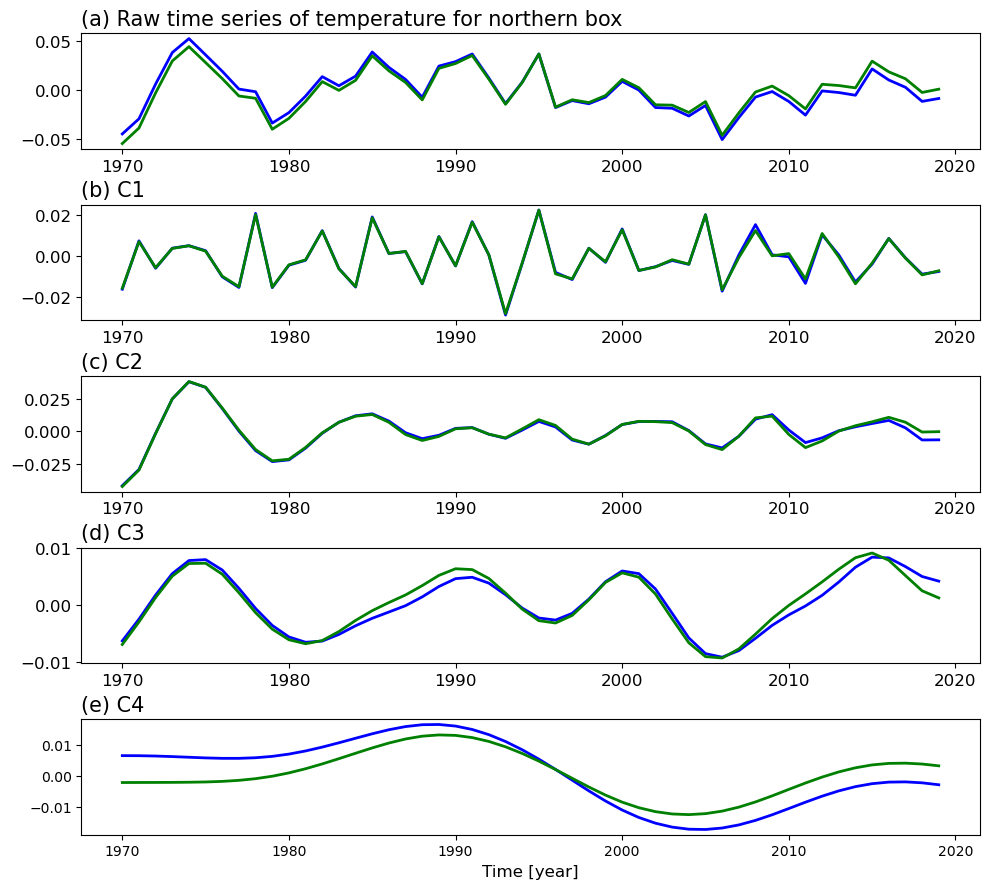

In [3]:
import matplotlib.pyplot as plt
t = np.arange(1970,2020,1)
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 9))
fontsize = 15
#plot time signal:
axs[0].set_title("(a) Raw time series of temperature for northern box", loc='left', fontsize=fontsize)
axs[0].plot(t, assi[0,:], 'b', linewidth=2)
axs[0].plot(t, hind[0,:], '-', color='green', linewidth=2, markersize=10, label = 'Raw')

# axs[0].set_xticklabels([])
plt.title('(a)', loc='left', fontsize=fontsize)

axs[1].plot(t, assi[1,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[1].plot(t, hind[1,:], '-', color='green', linewidth=2, markersize=10)
axs[1].set_title("(b) C1", loc='left', fontsize=fontsize)
# axs[1].set_ylim(-0.05, 0.05)   

axs[2].plot(t, assi[2,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[2].plot(t, hind[2,:], '-', color='green', linewidth=2, markersize=10)
axs[2].set_title("(c) C2", loc='left', fontsize=fontsize)

axs[3].plot(t, assi[3,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[3].plot(t, hind[3,:], '-', color='green', linewidth=2, markersize=10)
axs[3].set_title("(d) C3", loc='left', fontsize=fontsize)

axs[4].plot(t, assi[4,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[4].plot(t, hind[4,:], '-', color='green', linewidth=2, markersize=10)
axs[4].set_title("(e) C4", loc='left', fontsize=fontsize)
# axs[4].set_ylim(-0.05, 0.05)

axs[4].set_xlabel("Time [year]", fontsize='12')

axs[0].tick_params(axis='both', labelsize=12)
axs[1].tick_params(axis='both', labelsize=12)
axs[2].tick_params(axis='both', labelsize=12)
axs[3].tick_params(axis='both', labelsize=12)



# axs[6].set_ylim(-0.05, 0.05)
plt.tight_layout(h_pad=0.5, w_pad=None)

# fig.savefig('/work/uo1075/u241321/results/results.pdf',bbox_inches='tight')

plt.show()

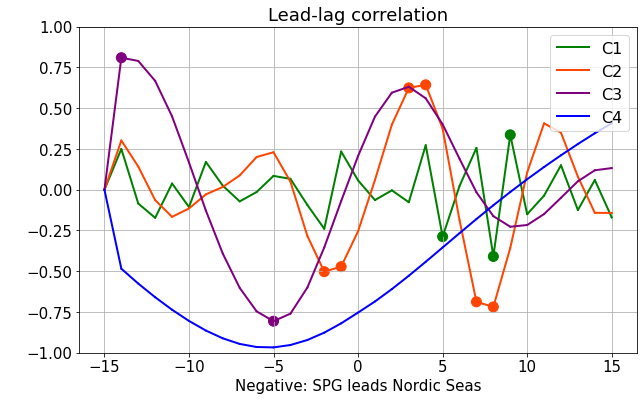

In [25]:

x = np.arange(-15,16)
y1 = corr_[0,:]
y2 = corr_[1,:]
y3 = corr_[2,:]
y4 = corr_[3,:]

fig, ax = plt.subplots(figsize = [10,6])

ax.plot(x, y1, '-', color='green', linewidth=2, markersize=10, label = 'C1')
ax.plot(x, y2, '-', color='orangered', linewidth=2, markersize=10, label = 'C2')
ax.plot(x, y3, '-', color='purple', linewidth=2, markersize=10, label = 'C3')
ax.plot(x, y4, '-', color='blue', linewidth=2, markersize=10, label = 'C4')
# ax.axhline(0.277, linewidth=2, color='blue', linestyle= 'dashed')
# ax.axhline(-0.277, linewidth=2, color='blue', linestyle= 'dashed')

ax.scatter(x, y1,  marksize_[0,:],color='green')
ax.scatter(x, y2,  marksize_[1,:],color='orangered')
ax.scatter(x, y3,  marksize_[2,:],color='purple')
ax.scatter(x, y4,  marksize_[3,:],color='blue')


ax.set(xlabel='Negative: SPG leads Nordic Seas', ylabel=' ',
       title='Lead-lag correlation')
ax.set_ylim(-1, 1)
ax.grid()
ax.legend(loc='upper right', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')

plt.rcParams["font.size"] = "15"
plt.show()
# fig.savefig('/work/uo1075/u241321/results/acc_ly_ave_comparison1_dt.pdf')

In [26]:
# Fourier analysis

def periods(ts):
    from scipy import signal
    lenth = len(ts)
    f, psd = signal.periodogram(ts[1:lenth],detrend=False)
    per=1/f
    max3=np.zeros((3))
    psdc=psd.copy()

    # Get the 3 larges periods
    for i in range(3):
        max3[i]=per[psdc==max(psdc)]
        psdc[psdc==max(psdc)]=0

    # Generate rednoise with first order autoregression model AR(1)
    # it equals to persistence forecast based on 1 year lag
    from sklearn.linear_model import LinearRegression
    vv = ts
    y = vv[1:lenth].reshape(-1,1)
    x = vv[0:lenth-1].reshape(-1,1)
    reg = LinearRegression(fit_intercept=True).fit(x, y).coef_
    intercept = LinearRegression(fit_intercept=True).fit(x, y).intercept_
    rednoise = np.zeros((lenth-1))

    for i in range(0,lenth-1,1):
        rednoise[i] = reg[0,0]*vv[i] + intercept 

    # Chi-square statistical significancant test of spectrum compared with a red-noise time seies
    # Fourier analysis on Red noise
    from scipy.stats import chi2
    f_red, psd_red = signal.periodogram(rednoise,detrend=False)
    # chi2.ppf(0.05,30,)
    chi2 = chi2.ppf([0.99, 0.95, 0.9], 2) # 0.01, 0.05, 0.1 significant level, respectively
    ff = len(f)
    sign_amplitude = np.zeros((ff,3))
    sign_amplitude[:,0] = psd_red*chi2[0]/2
    sign_amplitude[:,1] = psd_red*chi2[1]/2
    sign_amplitude[:,2] = psd_red*chi2[2]/2
    plt.rcParams.update({'font.size': 24})
    plt.rcParams.update({'figure.figsize':(8,6)})
    fig = plt.figure(1,facecolor='white')
    # ax = fig.add_axes([0.05, 0.3, 0.8, 1.0])
    p1=plt.plot(f,psd,color ='darkblue')
    p2=plt.plot(f_red,psd_red,color = "red")
    p3=plt.plot(f,sign_amplitude,color = "green")
    # plt.xlim(0,0.03)
    #plt.ylim(1e-8,4e-5)
    plt.xlabel('Frequency (yr$^{-1}$)')
    plt.ylabel('Spectral density')    
    return f, psd, max3, psd_red, sign_amplitude

f, psd, max3, psd_red, sign_amplititude = periods(Spg)
max3

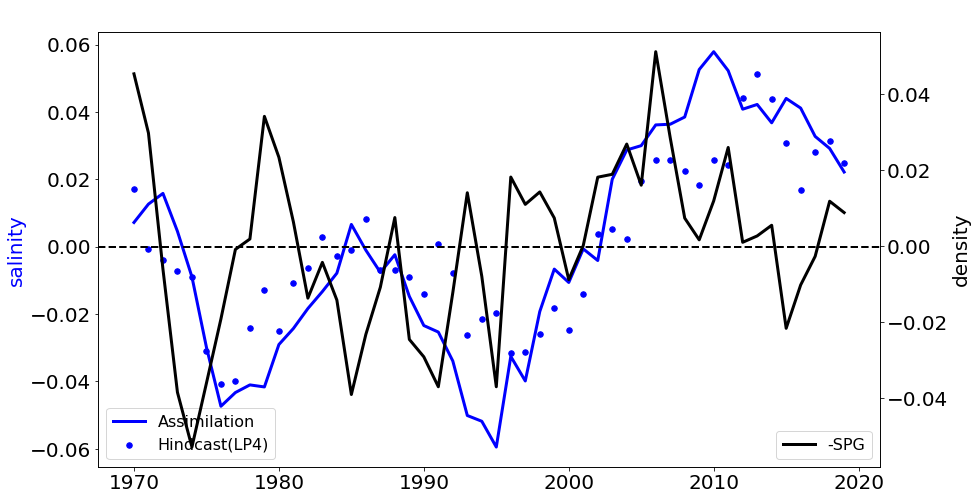

In [39]:
x = t
y0 = S
y1 = S_h[:,3]
# y2 = eIMFs[0,:]
# y3 = eIMFs[1,:]
# y4 = eIMFs[2,:]
# y5 = eIMFs[3,:]

fig, ax = plt.subplots(figsize = [14,8])
ax.plot(x, y0, '-',  color='blue', linewidth=3, markersize=10, label = 'Assimilation')
# ax.plot(x, y1, '-', color='blue', linewidth=3, markersize=10, label = 'Hindcast(LP4)')
ax.scatter(x, y1,  s=30,color='blue', label = 'Hindcast(LP4)')

# ax.plot(x, Spg, '-', color='blue', linewidth=3, markersize=10, label = 'SPG150-300m')

# ax.plot(x, y2, 'g-', linewidth=2, markersize=10, label = 'C1')
# ax.plot(x, lp, '-', linestyle='dashed', color='orangered', linewidth=2, markersize=10, label = 'Median(Assi)')
# ax.plot(x, lp_h[3,:], '-', color='orangered', linewidth=3, markersize=10, label = 'Median(LP4)')
# ax.plot(x, Spg, '-', color='black', linewidth=2, markersize=10, label = 'raw(SPG)')
# ax.plot(x, spg_m, '-', linestyle='dashed', color='black', linewidth=2, markersize=10, label = 'Median(SPG)')

ax.axhline(0, linewidth=2, color='black', linestyle= 'dashed')
ax.set(xlabel='', ylabel='',
       title=' ')
# ax.set_ylim(-0.1, 1.1)
# ax.grid()
ax.legend(loc='lower left', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('density', color='black')  # we already handled the x-label with ax1
ax2.plot(x, -Spg, color='black',linewidth=3,label = '-SPG')
ax.set_ylabel('salinity', color='blue')  # we already handled the x-label with ax1
ax2.legend(loc='lower right', fontsize='16')

plt.rcParams["font.size"] = "20"
plt.show()

In [27]:
y1.shape

(10,)

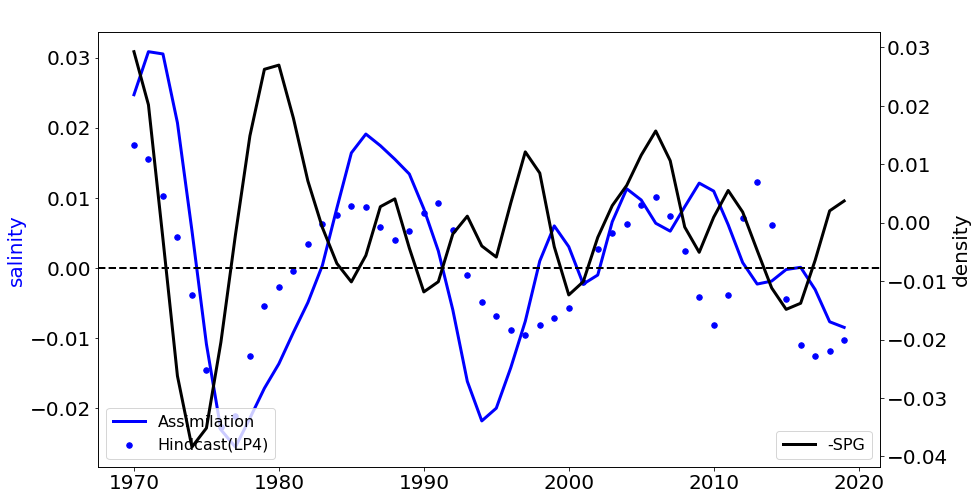

In [46]:
x = t
y0 = lp
y1 = lp_h[3,:]
# y2 = eIMFs[0,:]
# y3 = eIMFs[1,:]
# y4 = eIMFs[2,:]
# y5 = eIMFs[3,:]

fig, ax = plt.subplots(figsize = [14,8])
ax.plot(x, y0, '-',  color='blue', linewidth=3, markersize=10, label = 'Assimilation')
# ax.plot(x, y1, '-', color='blue', linewidth=3, markersize=10, label = 'Hindcast(LP4)')
ax.scatter(x, y1,  s=30,color='blue', label = 'Hindcast(LP4)')

# ax.plot(x, Spg, '-', color='blue', linewidth=3, markersize=10, label = 'SPG150-300m')

# ax.plot(x, y2, 'g-', linewidth=2, markersize=10, label = 'C1')
# ax.plot(x, lp, '-', linestyle='dashed', color='orangered', linewidth=2, markersize=10, label = 'Median(Assi)')
# ax.plot(x, lp_h[3,:], '-', color='orangered', linewidth=3, markersize=10, label = 'Median(LP4)')
# ax.plot(x, Spg, '-', color='black', linewidth=2, markersize=10, label = 'raw(SPG)')
# ax.plot(x, spg_m, '-', linestyle='dashed', color='black', linewidth=2, markersize=10, label = 'Median(SPG)')

ax.axhline(0, linewidth=2, color='black', linestyle= 'dashed')
ax.set(xlabel='', ylabel='',
       title=' ')
# ax.set_ylim(-0.1, 1.1)
# ax.grid()
ax.legend(loc='lower left', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('density', color='black')  # we already handled the x-label with ax1
ax2.plot(x, -spg_m, color='black',linewidth=3,label = '-SPG')
ax.set_ylabel('salinity', color='blue')  # we already handled the x-label with ax1
ax2.legend(loc='lower right', fontsize='16')

plt.rcParams["font.size"] = "20"
plt.show()

In [48]:
"""
Applying a bandpass filter
(the difference of two lowpass lanczos filters)
to a time-series.
==================================
This example demonstrates low pass filtering a time-series by applying a
weighted running mean over the time dimension.
The time-series used here is the EAR5 Reanalysis hourly 850hpa vorticity,
which is first averaged to daily data, and then filtered using two different
Lanczos filters, one to filter out time-scales of less than 3 years and one
to filter out time-scales of less than 10 years.
References
----------
    Duchon C. E. (1979) Lanczos Filtering in One and Two Dimensions.
    Journal of Applied Meteorology, Vol 18, pp 1016-1022.
"""

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, savefig
import matplotlib.colors
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER



def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]



In [58]:
    # window length for filters
    window = 7

    # construct 3 days and 10 days low pass filters
    hfw = low_pass_weights(window, 1. / 5.)
    lfw = low_pass_weights(window, 1. / 15.)
    weight_high = xr.DataArray(hfw, dims = ['window'])
    weight_low = xr.DataArray(lfw, dims = ['window'])

#     # Load the hourly 850hPa vorticity
#     fname = '/Users/serene.meng/EAR5_Test/tcseed/vort_850_06_to_11_2016'
#     ds = xr.open_dataset(fname)

#     '''
#     Results are presented for Jul–Oct although data in June and November
#     are also needed because the time filter requires extra data at the 
#     beginning and end of each year’s time series.
#     '''
#     hourly_data = ds.sel(time=slice("2016-06-07T00:00:00","2016-11-24T23:00:00"))['vo']

    # Since the EAR5 data are hourly, we first average them into daily data.
    daily_data = y

    # apply the filters using the rolling method with the weights
    lowpass_hf = daily_data.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
    lowpass_lf = daily_data.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

    # the bandpass is the difference of two lowpass filters.
    bandpass = lowpass_hf - lowpass_lf

# # find out low freuquent time scale
# cor = np.zeros(3)    
# cor[0] = np.corrcoef(bandpass[3:47], hp[3:47])[0,1]
# cor[1] = np.corrcoef(bandpass[3:47], lp[3:47])[0,1]
# cor[2] = np.corrcoef(bandpass[3:47], tp[3:47])[0,1]
# cor

# ts_h = bandpass
ts_bp = bandpass

<ipython-input-59-b52a8c409c11>:7: RuntimeWarning: divide by zero encountered in true_divide
  per=1/f


array([21.5       , 14.33333333,  8.6       ])

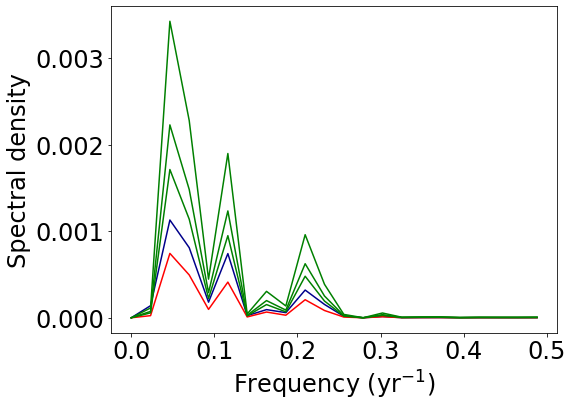

In [59]:
# Fourier analysis

def periods(ts):
    from scipy import signal
    lenth = len(ts)
    f, psd = signal.periodogram(ts[1:lenth],detrend='linear')
    per=1/f
    max3=np.zeros((3))
    psdc=psd.copy()

    # Get the 3 larges periods
    for i in range(3):
        max3[i]=per[psdc==max(psdc)]
        psdc[psdc==max(psdc)]=0

    # Generate rednoise with first order autoregression model AR(1)
    # it equals to persistence forecast based on 1 year lag
    from sklearn.linear_model import LinearRegression
    vv = ts.values
    y = vv[1:lenth].reshape(-1,1)
    x = vv[0:lenth-1].reshape(-1,1)
    reg = LinearRegression(fit_intercept=True).fit(x, y).coef_
    intercept = LinearRegression(fit_intercept=True).fit(x, y).intercept_
    rednoise = np.zeros((lenth-1))

    for i in range(0,lenth-1,1):
        rednoise[i] = reg[0,0]*vv[i] + intercept 

    # Chi-square statistical significancant test of spectrum compared with a red-noise time seies
    # Fourier analysis on Red noise
    from scipy.stats import chi2
    f_red, psd_red = signal.periodogram(rednoise,detrend='linear')
    # chi2.ppf(0.05,30,)
    chi2 = chi2.ppf([0.99, 0.95, 0.9], 2) # 0.01, 0.05, 0.1 significant level, respectively
    ff = len(f)
    sign_amplitude = np.zeros((ff,3))
    sign_amplitude[:,0] = psd_red*chi2[0]/2
    sign_amplitude[:,1] = psd_red*chi2[1]/2
    sign_amplitude[:,2] = psd_red*chi2[2]/2
    plt.rcParams.update({'font.size': 24})
    plt.rcParams.update({'figure.figsize':(8,6)})
    fig = plt.figure(1,facecolor='white')
    # ax = fig.add_axes([0.05, 0.3, 0.8, 1.0])
    p1=plt.plot(f,psd,color ='darkblue')
    p2=plt.plot(f_red,psd_red,color = "red")
    p3=plt.plot(f,sign_amplitude,color = "green")
    # plt.xlim(0,0.03)
    #plt.ylim(1e-8,4e-5)
    plt.xlabel('Frequency (yr$^{-1}$)')
    plt.ylabel('Spectral density')    
    return f, psd, max3, psd_red, sign_amplitude

f, psd, max3, psd_red, sign_amplititude = periods(ts_bp[3:47])
max3

In [ ]:
x = t
y0 = S
y1 = S_h[:,3]
# y2 = eIMFs[0,:]
# y3 = eIMFs[1,:]
# y4 = eIMFs[2,:]
# y5 = eIMFs[3,:]

fig, ax = plt.subplots(figsize = [14,8])
ax.plot(x, y0, '-', linestyle='dashed', color='blue', linewidth=2, markersize=10, label = 'Raw(Assi)')
ax.plot(x, y1, '-', color='blue', linewidth=3, markersize=10, label = 'Raw(LP4)')
# ax.plot(x, y2, 'g-', linewidth=2, markersize=10, label = 'C1')
ax.plot(x, lp, '-', linestyle='dashed', color='orangered', linewidth=2, markersize=10, label = 'Median(Assi)')
ax.plot(x, lp_h[3,:], '-', color='orangered', linewidth=3, markersize=10, label = 'Median(LP4)')
# ax.plot(x, Spg, '-', color='black', linewidth=2, markersize=10, label = 'raw(SPG)')
# ax.plot(x, spg_m, '-', linestyle='dashed', color='black', linewidth=2, markersize=10, label = 'Median(SPG)')

ax.axhline(0, linewidth=2, color='black', linestyle= 'dashed')
ax.set(xlabel='Lead year', ylabel=' ',
       title=' ')
# ax.set_ylim(-0.1, 1.1)
# ax.grid()
ax.legend(loc='lower right', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')

plt.rcParams["font.size"] = "20"
plt.show()

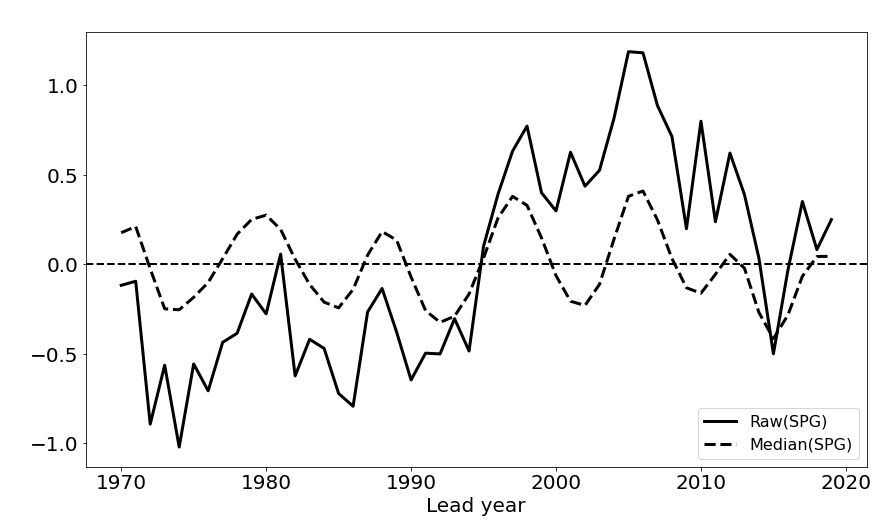

In [43]:

fig, ax = plt.subplots(figsize = [14,8])
ax.plot(x, Spg, '-', color='black', linewidth=3, markersize=10, label = 'Raw(SPG)')
ax.plot(x, spg_m, '-', linestyle='dashed', color='black', linewidth=3, markersize=10, label = 'Median(SPG)')

ax.axhline(0, linewidth=2, color='black', linestyle= 'dashed')
ax.set(xlabel='Lead year', ylabel=' ',
       title=' ')
# ax.set_ylim(-0.1, 1.1)
# ax.grid()
ax.legend(loc='lower right', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')

plt.rcParams["font.size"] = "20"
plt.show()

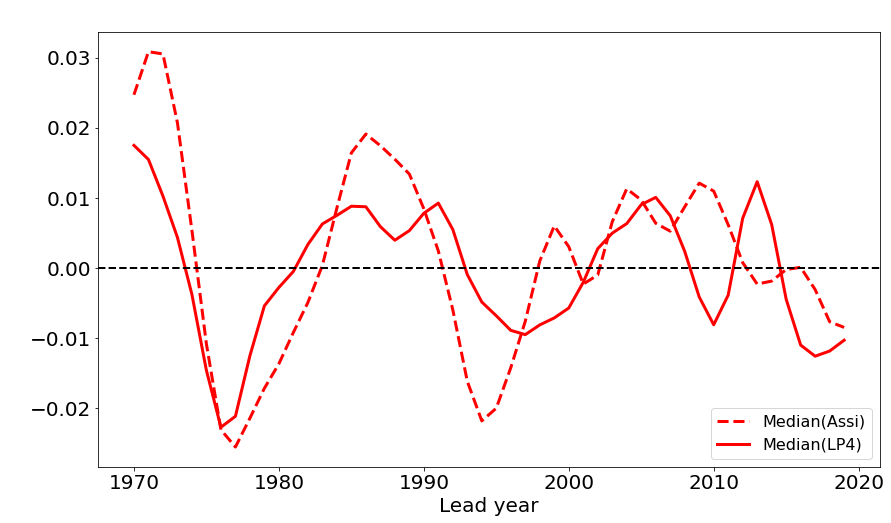

In [18]:
x = t
y0 = lp
y1 = lp_h[3,:]
# y2 = eIMFs[0,:]
# y3 = eIMFs[1,:]
# y4 = eIMFs[2,:]
# y5 = eIMFs[3,:]

fig, ax = plt.subplots(figsize = [14,8])
ax.plot(x, y0, '-', linestyle='dashed', color='red', linewidth=3, markersize=10, label = 'Median(Assi)')
ax.plot(x, y1, '-', color='red', linewidth=3, markersize=10, label = 'Median(LP4)')
# ax.plot(x, y2, 'g-', linewidth=2, markersize=10, label = 'C1')
# ax.plot(x, y3, '-', color='orangered', linewidth=2, markersize=10, label = 'C2')
# ax.plot(x, y4, '-', color='purple', linewidth=2, markersize=10, label = 'C3')
# ax.plot(x, y5, '-', color='blue', linewidth=2, markersize=10, label = 'C4')


ax.axhline(0, linewidth=2, color='black', linestyle= 'dashed')
ax.set(xlabel='Lead year', ylabel=' ',
       title=' ')
# ax.set_ylim(-0.1, 1.1)
# ax.grid()
ax.legend(loc='lower right', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')

plt.rcParams["font.size"] = "20"
plt.show()

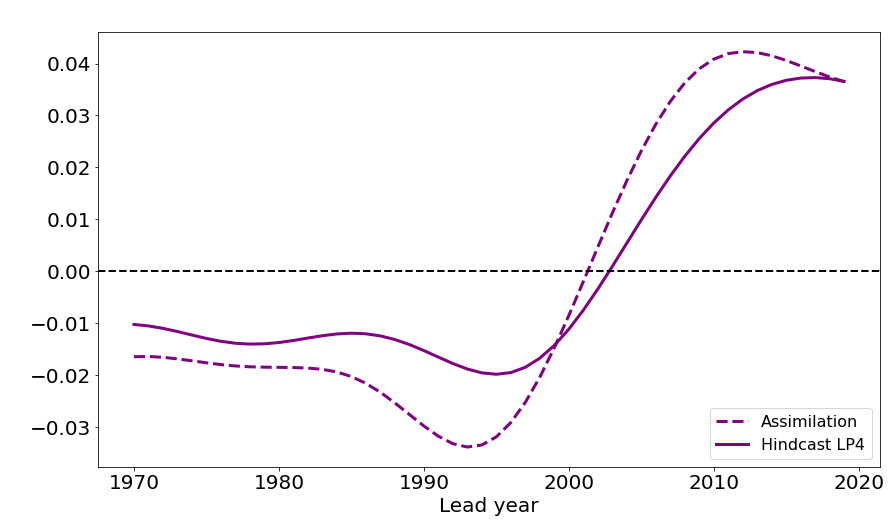

In [17]:
x = t
y0 = tp
y1 = tp_h[3,:]
# y2 = eIMFs[0,:]
# y3 = eIMFs[1,:]
# y4 = eIMFs[2,:]
# y5 = eIMFs[3,:]

fig, ax = plt.subplots(figsize = [14,8])
ax.plot(x, y0, '-', linestyle='dashed', color='purple', linewidth=3, markersize=10, label = 'Assimilation')
ax.plot(x, y1, '-', color='purple', linewidth=3, markersize=10, label = 'Hindcast LP4')
# ax.plot(x, y2, 'g-', linewidth=2, markersize=10, label = 'C1')
# ax.plot(x, y3, '-', color='orangered', linewidth=2, markersize=10, label = 'C2')
# ax.plot(x, y4, '-', color='purple', linewidth=2, markersize=10, label = 'C3')
# ax.plot(x, y5, '-', color='blue', linewidth=2, markersize=10, label = 'C4')


ax.axhline(0, linewidth=2, color='black', linestyle= 'dashed')
ax.set(xlabel='Lead year', ylabel=' ',
       title=' ')
# ax.set_ylim(-0.1, 1.1)
# ax.grid()
ax.legend(loc='lower right', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')

plt.rcParams["font.size"] = "20"
plt.show()

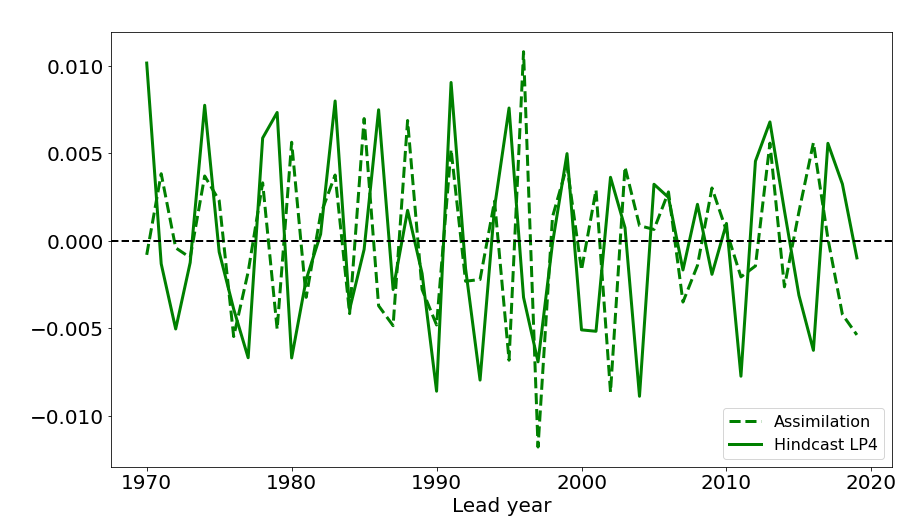

In [15]:
x = t
y0 = hp
y1 = hp_h[3,:]
# y2 = eIMFs[0,:]
# y3 = eIMFs[1,:]
# y4 = eIMFs[2,:]
# y5 = eIMFs[3,:]

fig, ax = plt.subplots(figsize = [14,8])
ax.plot(x, y0, '-', linestyle='dashed', color='green', linewidth=3, markersize=10, label = 'Assimilation')
ax.plot(x, y1, '-', color='green', linewidth=3, markersize=10, label = 'Hindcast LP4')
# ax.plot(x, y2, 'g-', linewidth=2, markersize=10, label = 'C1')
# ax.plot(x, y3, '-', color='orangered', linewidth=2, markersize=10, label = 'C2')
# ax.plot(x, y4, '-', color='purple', linewidth=2, markersize=10, label = 'C3')
# ax.plot(x, y5, '-', color='blue', linewidth=2, markersize=10, label = 'C4')


ax.axhline(0, linewidth=2, color='black', linestyle= 'dashed')
ax.set(xlabel='Lead year', ylabel=' ',
       title=' ')
# ax.set_ylim(-0.1, 1.1)
# ax.grid()
ax.legend(loc='lower right', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')

plt.rcParams["font.size"] = "20"
plt.show()

In [56]:
fre, spe, pct1, max5, meanred = periods(spg_m,1,returnPeriods=True, nsim=1000)
max5[0,2]  # largest period

<ipython-input-52-9f074e9b63f5>:58: RuntimeWarning: divide by zero encountered in true_divide
  per=1/f


25.0

In [41]:
data       = xr.open_dataset("/work/uo1075/u241321/data_cdo/salinity_1969-2019_assi_dt_5000.nc") 
lat_min, lat_max = (60,80) # region3 
lon_min, lon_max = (-20,20)
var11 = data['__xarray_dataarray_variable__'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
var1 = np.mean(np.mean(var11, axis=1)[:,10:15,:,:],1)

# weight average 
weights = np.cos(np.deg2rad(var1.lat))
weights.name = "weights"
air_weighted = var1.weighted(weights)
y = air_weighted.mean(("lon", "lat"))
S_d = y.values
S_d

array([ 0.04191989,  0.04595911,  0.04771884,  0.03504835,  0.02010558,
       -0.00221005, -0.02116015, -0.01849725, -0.01765188, -0.01967566,
       -0.00849791, -0.00515116, -0.00063963,  0.00298697,  0.00703022,
        0.02008387,  0.01101031,  0.00302315,  0.00682946, -0.00695586,
       -0.01703296, -0.02038265, -0.03040424, -0.04800075, -0.05112864,
       -0.06019635, -0.03470375, -0.04340847, -0.0242134 , -0.01302688,
       -0.01841317, -0.00985753, -0.01472936,  0.00798562,  0.01525472,
        0.01513208,  0.01986526,  0.01865389,  0.01938046,  0.03205681,
        0.03594282,  0.02888872,  0.01602885,  0.01601974,  0.00915527,
        0.01497333,  0.01069089,  0.00086528, -0.00412515, -0.01254745])

In [45]:
np.corrcoef(S, tp)

array([[1.       , 0.8874702],
       [0.8874702, 1.       ]])